# Extraction of One spectrum
=============================================

- Creation : Tuesday 2016 June 14th
- Update / July 2nd 2016
- Author Sylvie Dagoret-Campagne 
- affiliation : LAL/IN2P3/CNRS

Raw Spectrum of HD158485


## 1) Import package

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits

import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [2]:
from scipy import stats 
from scipy import ndimage
import os
from datetime import datetime, timedelta

In [3]:
import libMonocamBaseImages           # my tool library written to do that CCD reduction

In [4]:
now=datetime.utcnow()  # choose UTC time
datestr=str(now)
print 'standard date format for the analysis :',datestr
#  want the following format '2016-05-10T11:55:27.267'
date_of_analysis=now.strftime('%Y-%m-%dT%H:%M:%S')
print 'fits date format for the analysis : ',date_of_analysis

standard date format for the analysis : 2016-07-03 21:05:39.815488
fits date format for the analysis :  2016-07-03T21:05:39


In [5]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.background import Background2D

## Few Definition

In [6]:
object_name='HD158485_grat_120'

In [7]:
path='./HD158485_grat'
basefilename='AssScImHD158485_grat_120.fits' # check master bias
filename=os.path.join(path,basefilename)
outputfigfilename='ScienceImageAssemblerInput_img.pdf'
outputfigfilename2='ReorderedImage_'+object_name+'_img.pdf'
outputfigfilename3='SingleImage_'+object_name+'_img.pdf'
outputfigfilename4='RotatedImage_'+object_name+'_img.pdf'
outputfigfilename5='SpectrumRegion_'+object_name+'_img.pdf'
outputfigfilename6='SpectrumHisto_'+object_name+'_img.pdf'
outputfigfilename7='SpectrumLogHisto_'+object_name+'_img.pdf'

## Analysis Selection

In [8]:
RotationAngleOptimisation=False

In [9]:
BackgroundSubtractionFlag=False

In [10]:
CropLittleStarFlag=False

## 4) Read the images

In [11]:
allimages = []
ccd_chan = ccdproc.CCDData.read(filename, hdu=0,unit='adu') 
allimages.append(ccd_chan)

## 5) Shows the images

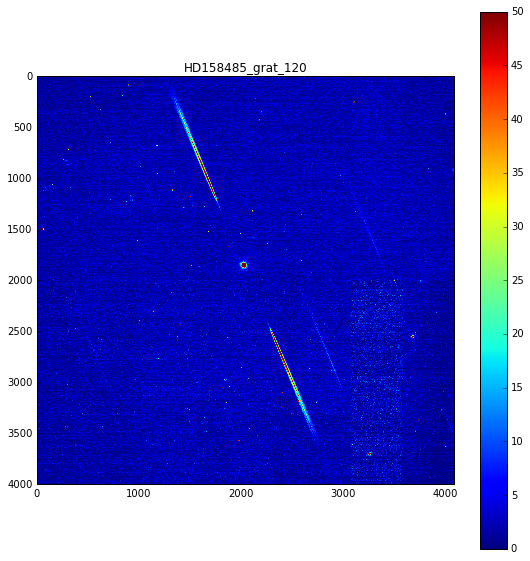

In [12]:
fig, ax = plt.subplots(figsize=(8, 8))
img=ax.imshow(ccd_chan,vmin=0,vmax=50.)
plt.title(object_name)
plt.tight_layout()
plt.colorbar(img)
plt.savefig(outputfigfilename3)

## Background subtraction

The user should decide if the background must be subtracted or not

In [13]:
if BackgroundSubtractionFlag:
    bkg = Background2D(ccd_chan, (100, 100), filter_size=(3, 3),method='median')
    data=ccd_chan - bkg.background
    print('median background = ',bkg.background_median)
    print('median rms = ',bkg.background_rms_median)
else:
    data=ccd_chan

This calculation of sky background has to be used to erase the central star

In [14]:
skybackground=np.median(data)
sigma_skybackground=np.std(data)

In [15]:
print 'remaing sky background = {:2.3f} +/- {:2.3f}'.format(skybackground,sigma_skybackground)

remaing sky background = 2.121 +/- 62.998


## 8.) Image rotation and spectrum region selection

In [16]:
rotation_angle_test=np.linspace(67.0,67.5,100)

In [17]:
NBTESTS=rotation_angle_test.shape[0]

### Optimisation to find the best rotation angle

In [18]:
flux=np.zeros(NBTESTS)

In [19]:
w=10 # spectrum width selection
ws=75 # star width

In [20]:
if RotationAngleOptimisation:
    for index,angle in np.ndenumerate(rotation_angle_test):
        rotated_image=ndimage.interpolation.rotate(data,angle)
        imax,jmax = np.unravel_index(rotated_image.argmax(), rotated_image.shape)
        region=rotated_image[imax-w: imax+w,480:4830]  # extract the region
        imax2,jmax2 = np.unravel_index(region.argmax(), region.shape)
        region[:,jmax2-ws:jmax2+ws]=skybackground  # suppress central star
        flux[index]=region.sum()
        print 'index = {} angle={:2.4f} flux = {:2.0f}'.format(index,angle,flux[index])

In [21]:
if RotationAngleOptimisation:
    dflux=flux-flux.max()
    plt.plot(rotation_angle_test,dflux)

In [22]:
if not RotationAngleOptimisation:
    selected_angle=67.35353535

In [23]:
if RotationAngleOptimisation:
    selected_angle= rotation_angle_test[np.where(flux==flux.max())]

In [24]:
print 'selected angle = {} degrees'.format(selected_angle)

selected angle = 67.35353535 degrees


In [25]:
rotated_image=ndimage.interpolation.rotate(data,selected_angle)

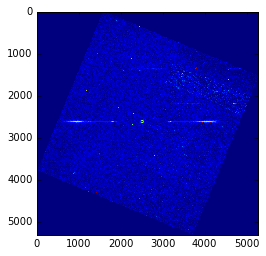

In [26]:
plt.imshow(rotated_image,vmin=0,vmax=50)

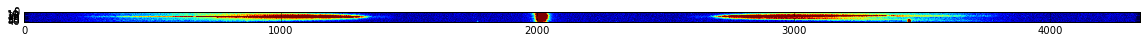

In [27]:
wcheck=20
imax,jmax = np.unravel_index(rotated_image.argmax(), rotated_image.shape)
check_region=np.copy(rotated_image[imax-wcheck: imax+wcheck,480:4830])  # extract the region
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(check_region,vmin=0,vmax=50)

### Do the rotation for the selected  angle

In [28]:
themaximum=rotated_image.max()

In [29]:
imax,jmax = np.unravel_index(rotated_image.argmax(), rotated_image.shape)
print imax,' ',jmax

2622   2493


In [30]:
np.where(rotated_image==rotated_image.max())

(array([2622]), array([2493]))

In [31]:
w=10

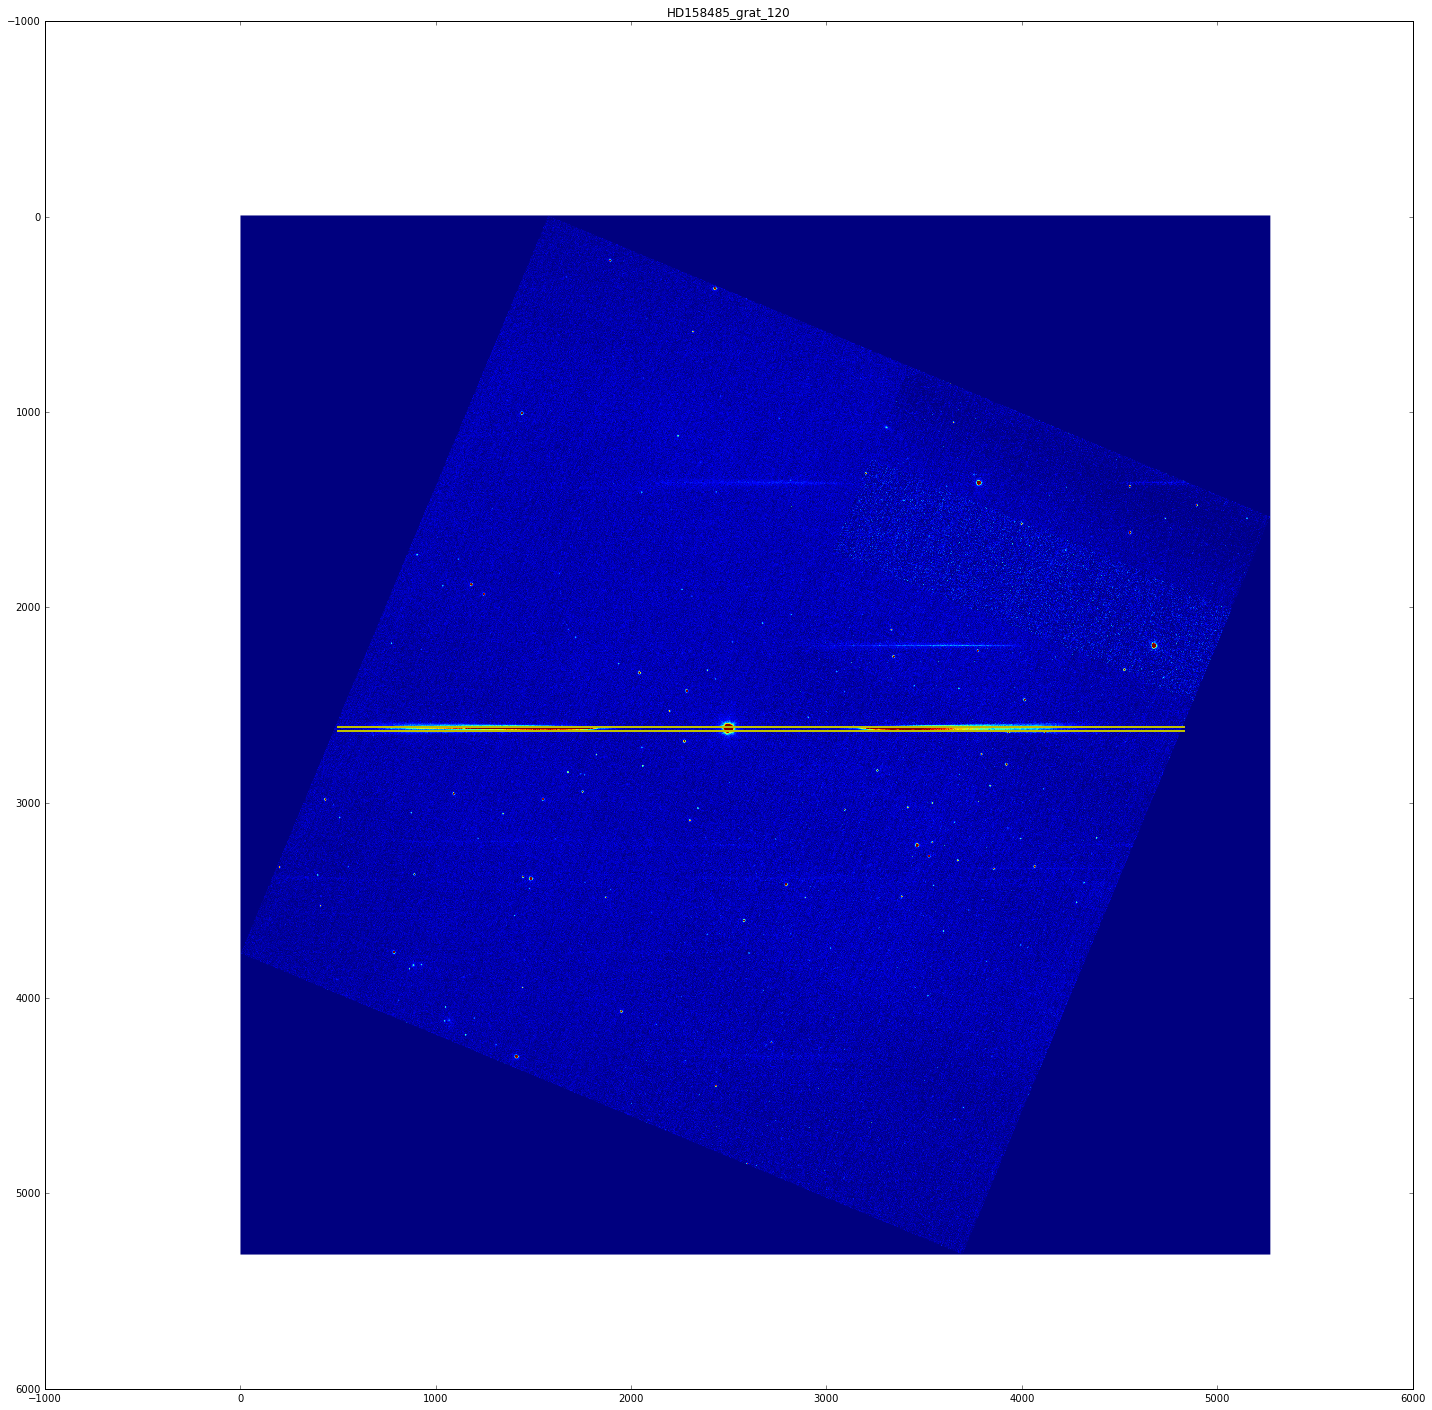

In [32]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(rotated_image,vmin=0,vmax=50.)
ax.plot([500, 4830], [imax-w, imax-w], color='y', linestyle='-', linewidth=2)
ax.plot([500, 4830], [imax+w, imax+w], color='y', linestyle='-', linewidth=2)
plt.title(object_name)
plt.tight_layout()
plt.savefig(outputfigfilename4)

In [33]:
SpectrumRegion=rotated_image[imax-100: imax+100,480:4830]

In [34]:
SpectrumRegionNew=np.copy(SpectrumRegion)   # must coy the original spectrum not to overwrite the original

In [35]:
imax2,jmax2 = np.unravel_index(SpectrumRegionNew.argmax(), SpectrumRegionNew.shape)
print imax2,' ',jmax2

100   2013


In [36]:
SpectrumRegionNew[:,jmax2-ws: jmax2+ws]=skybackground # remove the big central star and replace by background

### Extract the region of the spectrum  from the rotated image

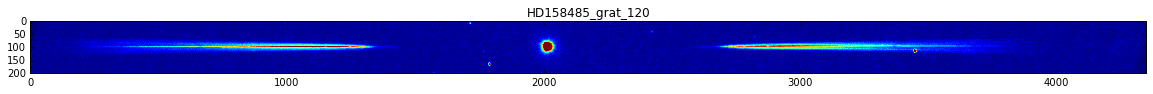

In [37]:
# show the original spectrum region
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(SpectrumRegion,vmin=0,vmax=100.)
plt.title(object_name)

### Show the spectrum region with the central star removed

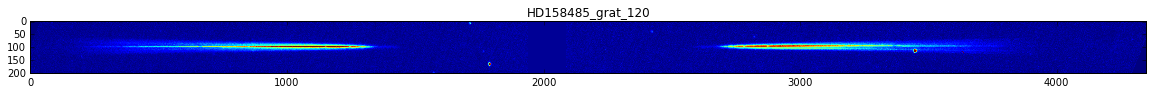

In [38]:
# show the spectrum cropped from central star
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(SpectrumRegionNew,vmin=0,vmax=100.)
plt.title(object_name)

### Crop little star on the right wing

In [39]:
ymax3,xmax3=np.where(SpectrumRegionNew==SpectrumRegionNew.max())

In [40]:
print ymax3,xmax3

[117] [3446]


In [41]:
littlestarsize=10    # be carefull the extinction of the tiny star should not be that big

In [42]:
SpectrumRegionNew.shape

(200, 4350)

In [43]:
X_SRN=np.arange(SpectrumRegionNew.shape[1])
Y_SRN=np.arange(SpectrumRegionNew.shape[0])

In [44]:
XV_SRN, YV_SRN = np.meshgrid(X_SRN, Y_SRN, sparse=False, indexing='ij')

In [45]:
Xlsr,Ylsr=np.where( (XV_SRN-xmax3)**2+(YV_SRN-ymax3)**2<littlestarsize**2)

In [46]:
selected_indexes=zip(Ylsr,Xlsr)

In [47]:
for ii,jj in selected_indexes:
    SpectrumRegionNew[ii,jj]=skybackground

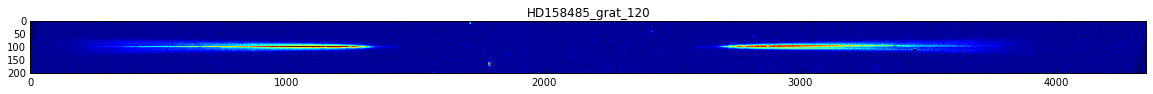

In [48]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(SpectrumRegionNew,vmin=0,vmax=100.)
plt.title(object_name)

## Optimize the width


The width is varied from zero to the Spectrum Region width to study the "encircled energy" versus width

In [49]:
widths=np.arange(1,100,1)

In [50]:
widths

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [51]:
NBWIDTHS=widths.shape[0]

In [52]:
profile_list=[]
integratedflux=np.zeros(NBWIDTHS)

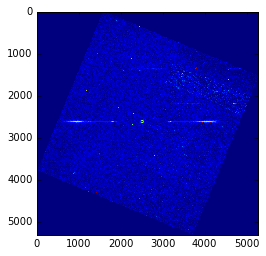

In [53]:
plt.imshow(rotated_image,vmin=0,vmax=50)  

In [54]:
#imax,jmax = np.unravel_index(SpectrumRegionNew.argmax(), SpectrumRegionNew.shape)
#print imax,' ',jmax
for index,thew in np.ndenumerate(widths):
    
    TestRegion=np.copy(rotated_image[imax-thew: imax+thew,480:4830])
    imax2,jmax2 = np.unravel_index(TestRegion.argmax(), TestRegion.shape)
    TestRegion[:,jmax2-ws: jmax2+ws]=skybackground  # remove the star
    TestRegion=TestRegion-skybackground  # now must remove the sky background to all the pixels
    profile=np.sum(TestRegion,axis=1)
    integratedflux[index]=profile.sum()
    profile_list.append(profile)
    

In [55]:
imax2,jmax2 = np.unravel_index(SpectrumRegion.argmax(), SpectrumRegion.shape)
print imax2,' ',jmax2

for index,thew in np.ndenumerate(widths):
    
    TestRegion=np.copy(SpectrumRegionNew[imax2-thew: imax2+thew,:])   # this spectrum has already the little star removed
    #imax2,jmax2 = np.unravel_index(TestRegion.argmax(), TestRegion.shape)
    #TestRegion[:,jmax2-ws: jmax2+ws]=skybackground  # remove the star
    TestRegion=TestRegion-skybackground  # now must remove the sky background to all the pixels
    profile=np.sum(TestRegion,axis=1)
    integratedflux[index]=profile.sum()
    profile_list.append(profile)
    

100   2013


In [56]:
integratedflux=integratedflux/integratedflux.max()

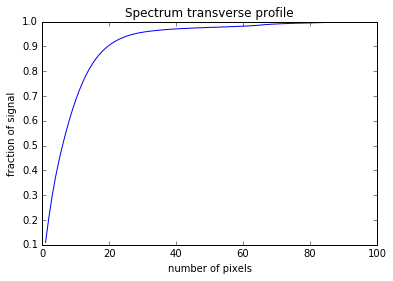

In [57]:
plt.plot(widths,integratedflux)
plt.title('Spectrum transverse profile')
plt.xlabel('number of pixels')
plt.ylabel('fraction of signal')

### Select the final window width for the spectrum

In [58]:
wsel=10  # should be 20, but set 10 due to the star

## 9) Extraction of the spectrum from the image

In [59]:
imax,jmax = np.unravel_index(rotated_image.argmax(), rotated_image.shape)
print imax,' ',jmax
SelectedSpectrumRegion=np.copy(rotated_image[imax-wsel: imax+wsel,480:4830])

2622   2493


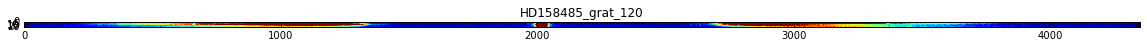

In [60]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(SelectedSpectrumRegion,vmin=0,vmax=50.)
plt.title(object_name)

#### remove central star

In [61]:
imax2,jmax2 = np.unravel_index(SelectedSpectrumRegion.argmax(), SelectedSpectrumRegion.shape)
print imax2,' ',jmax2

10   2013


In [62]:
SelectedSpectrumRegion[:,jmax2-ws: jmax2+ws]=skybackground

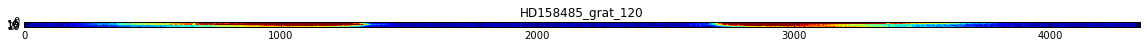

In [63]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(SelectedSpectrumRegion,vmin=0,vmax=50.)
plt.title(object_name)
#plt.tight_layout()
plt.savefig(outputfigfilename5)

In [64]:
if CropLittleStarFlag:
    ymax4,xmax4=np.where(SelectedSpectrumRegion==SelectedSpectrumRegion.max())
    X_SRN=np.arange(SelectedSpectrumRegion.shape[1])
    Y_SRN=np.arange(SelectedSpectrumRegion.shape[0])
    XV_SRN, YV_SRN = np.meshgrid(X_SRN, Y_SRN, sparse=False, indexing='ij')
    Xlsr,Ylsr=np.where( (XV_SRN-xmax4)**2+(YV_SRN-ymax4)**2<littlestarsize**2)
    selected_indexes=zip(Ylsr,Xlsr)
    for ii,jj in selected_indexes:
        SelectedSpectrumRegion[ii,jj]=skybackground

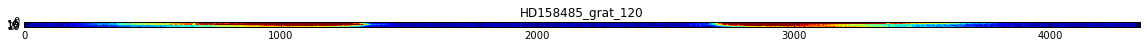

In [65]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(SelectedSpectrumRegion,vmin=0,vmax=50.)
plt.title(object_name)
#plt.tight_layout()
plt.savefig(outputfigfilename5)

In [66]:
spectrum=np.sum(SelectedSpectrumRegion,axis=0)

In [67]:
spectrum

array([ 21.19977047,  28.70379252,  32.79936004, ...,   0.        ,
         0.        ,   0.        ])

## 10.)  Plot the spectrum

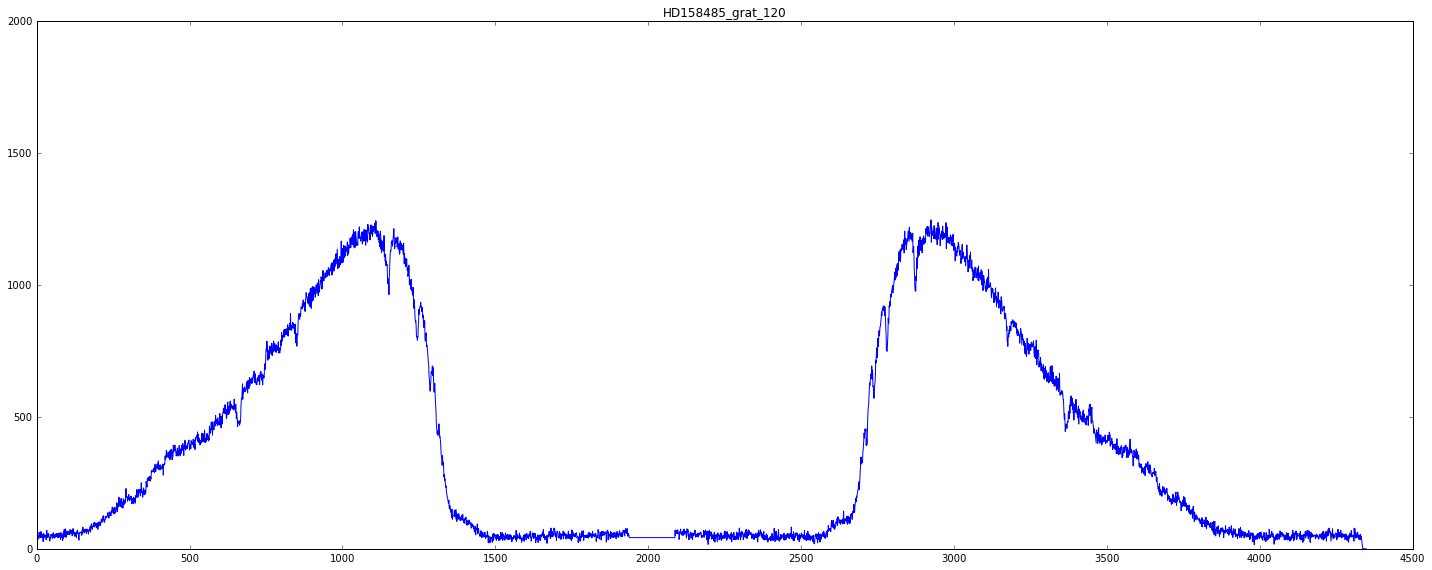

In [68]:
fig, ax = plt.subplots(figsize=(20, 8))
plt.plot(spectrum)
plt.ylim(0.,2000.)
plt.title(object_name)
plt.tight_layout()
plt.savefig(outputfigfilename6)

In [69]:
def SeparateSpectra(inspectra,x0):
    '''
    Cut the two spectra
    '''
    rightspectra=inspectra[x0:]
    revleftspectra=inspectra[:x0]
    leftspectra=   revleftspectra[::-1]
    rightspectra=rightspectra[np.where(rightspectra>0)]
    leftspectra=leftspectra[np.where(leftspectra>0)]
    return leftspectra,rightspectra

In [70]:
def GetSpectrumBackground(inspectra,start,stop,skybg):
    '''
    Return the background    
    '''
    cropedbg=inspectra[start:stop]
    purebg=cropedbg[np.where(cropedbg!=skybg)]  # remove region of the bing star
    
    return purebg

In [71]:
def DiffSpectra(spec1,spec2,bg):
    '''
    Make the difference of the tow spectra 
    
    '''
    N1=spec1.shape[0]
    N2=spec2.shape[0]
    N=np.min([N1,N2])
    spec1_croped=spec1[0:N]
    spec2_croped=spec2[0:N]
    diff_spec=np.average((spec1_croped-spec2_croped)**2)/rmsspecbg**2
    return diff_spec  

In [72]:
specbg=GetSpectrumBackground(spectrum,1500,2500,skybackground*wsel)

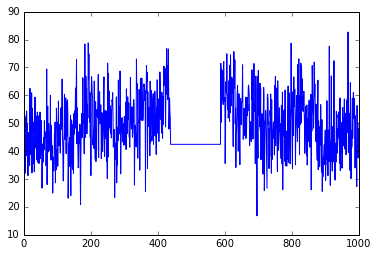

In [73]:
plt.plot(specbg)

In [74]:
avspecbg=np.median(specbg)
rmsspecbg=specbg.std()

print 'spectra noise = {} +/- {} '.format(avspecbg,rmsspecbg)

spectra noise = 47.1507475185 +/- 10.2399006964 


In [75]:
spec1,spec2=SeparateSpectra(spectrum,2013)

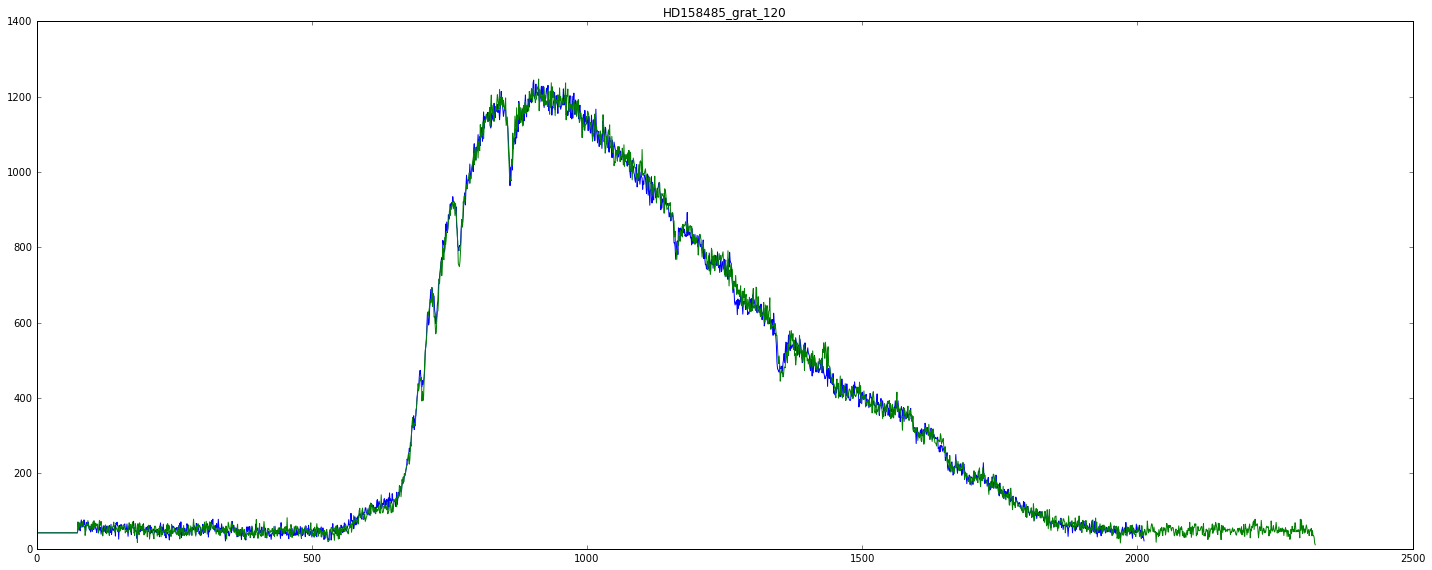

In [76]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(spec1)
ax.plot(spec2)
plt.title(object_name)
plt.tight_layout()


In [77]:
def FindCenter(fullspectrum,xmin,xmax,specbg):
    '''
    '''
    
    all_x0=np.arange(xmin,xmax,1)
    NBPOINTS=np.shape(all_x0)
    chi2=np.zeros(NBPOINTS)
    for idx,x0 in np.ndenumerate(all_x0):
        spec1,spec2=SeparateSpectra(fullspectrum,x0)
        chi2[idx]=DiffSpectra(spec1,spec2,specbg)
    return all_x0,chi2

In [78]:
origins,thechi2=FindCenter(spectrum,1500,2500,rmsspecbg)

(0, 200.0)

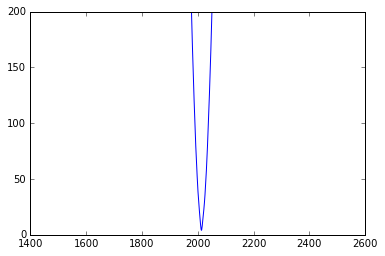

In [79]:
plt.plot(origins,thechi2)
plt.ylim(0,200.)

In [80]:
indexmin=np.where(thechi2==thechi2.min())[0]
theorigin=origins[indexmin]
print indexmin[0],theorigin[0],thechi2.min()

513 2013 4.05221655335


In [81]:
print thechi2[515]

5.78570566617


In [82]:
spec1,spec2=SeparateSpectra(spectrum,theorigin[0])

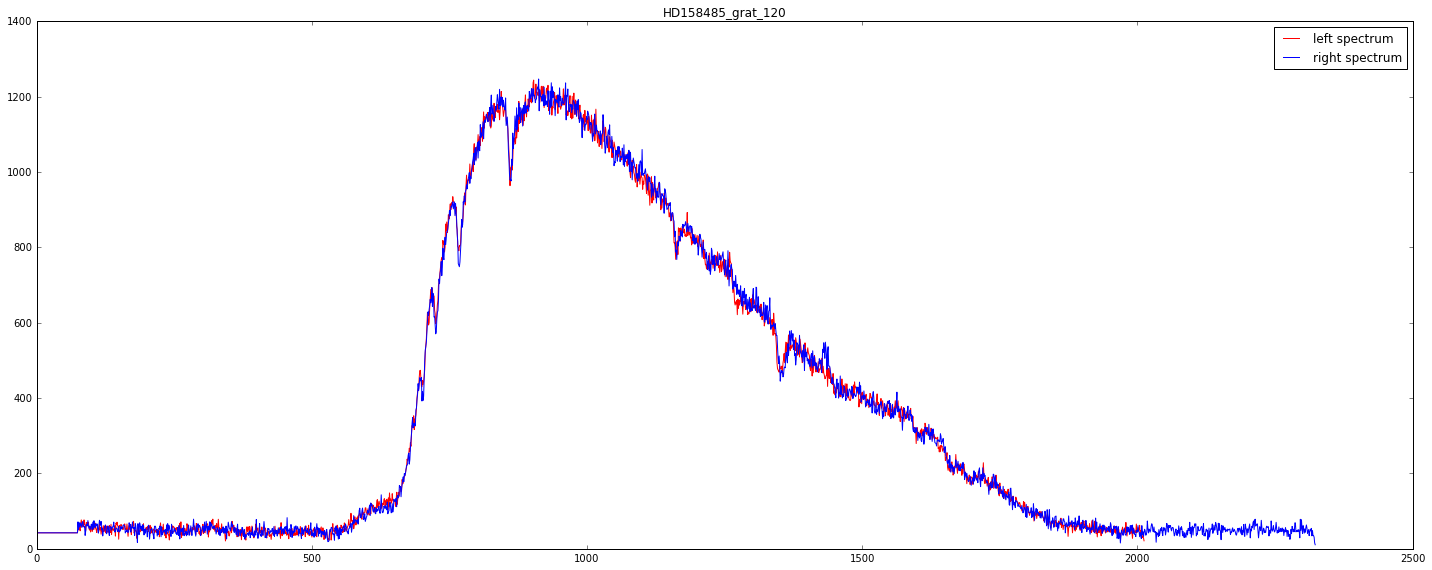

In [83]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(spec1,color='r',label='left spectrum')
ax.plot(spec2,color='b',label='right spectrum')
plt.title(object_name)
plt.legend(loc='best')
plt.tight_layout()

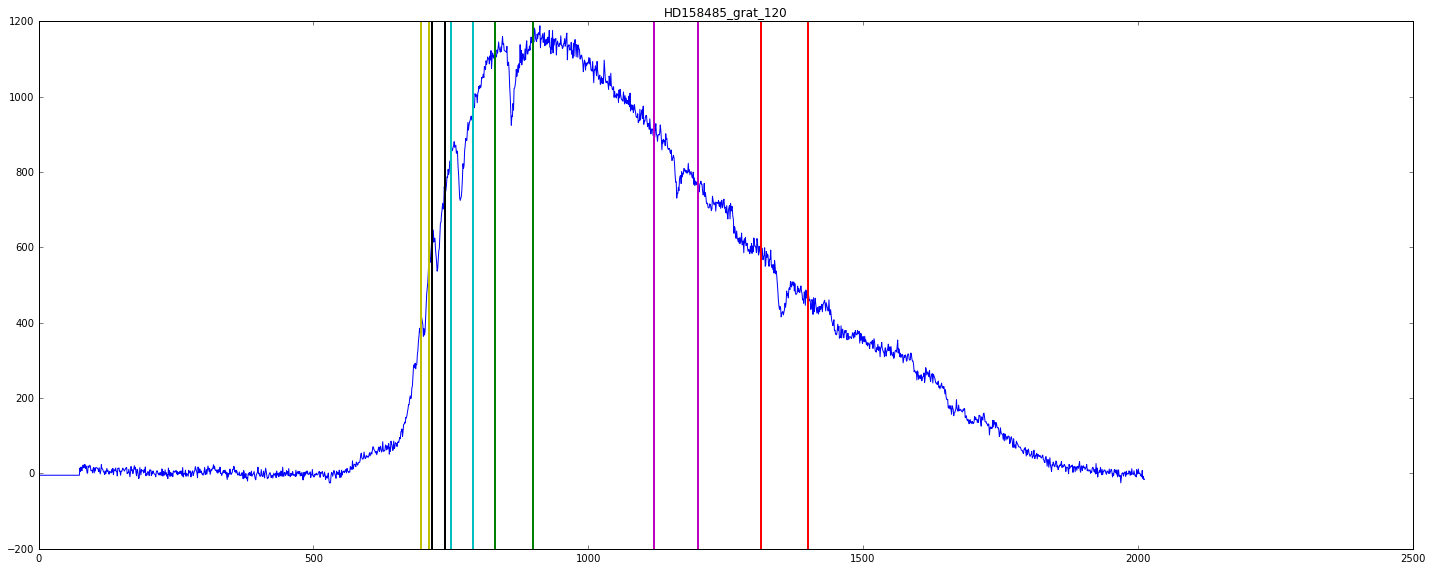

In [84]:
N1=spec1.shape[0]
N2=spec2.shape[0]
N=np.min([N1,N2])
spec1_croped=spec1[0:N]
spec2_croped=spec2[0:N]
specsum=0.5*(spec1_croped+spec2_croped)-avspecbg

fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(specsum)
# O2 Frauwnoffer A 759.370
ax.plot([1315, 1315], [-200,1200], color='r', linestyle='-', linewidth=2)
ax.plot([1400, 1400], [-200,1200], color='r', linestyle='-', linewidth=2)

# H-alpha : Hα     656.281 nm
ax.plot([1120, 1120], [-200,1200], color='m', linestyle='-', linewidth=2)
ax.plot([1200, 1200], [-200,1200], color='m', linestyle='-', linewidth=2)

# H-beta : Hβ     486.134 nm
ax.plot([830, 830], [-200,1200], color='g', linestyle='-', linewidth=2)
ax.plot([900, 900], [-200,1200], color='g', linestyle='-', linewidth=2)

# H-gamma : Hγ     434.047 nm
ax.plot([750, 750], [-200,1200], color='c', linestyle='-', linewidth=2)
ax.plot([790, 790], [-200,1200], color='c', linestyle='-', linewidth=2)


# H-delta : Hδ     410.175 nm
ax.plot([715, 715], [-200,1200], color='k', linestyle='-', linewidth=2)
ax.plot([740, 740], [-200,1200], color='k', linestyle='-', linewidth=2)

# H-epsilon : H epsilon 397,0 nm
ax.plot([695, 695], [-200,1200], color='y', linestyle='-', linewidth=2)
ax.plot([710, 710], [-200,1200], color='y', linestyle='-', linewidth=2)

plt.title(object_name)
plt.tight_layout()

In [85]:
peak_O2=np.min(specsum[1315:1400])
indexes_O2=np.where(specsum==peak_O2)
print indexes_O2, peak_O2

(array([1351]),) 415.630121502


In [86]:
peak_Halpha=np.min(specsum[1120:1200])
indexes_Halpha=np.where(specsum==peak_Halpha)
print indexes_Halpha, peak_Halpha

(array([1161]),) 730.941250898


In [87]:
peak_Hbeta=np.min(specsum[830:900])
indexes_Hbeta=np.where(specsum==peak_Hbeta)
print indexes_Hbeta, peak_Hbeta

(array([860]),) 924.259413815


In [88]:
peak_Hgamma=np.min(specsum[750:790])
indexes_Hgamma=np.where(specsum==peak_Hgamma)
print indexes_Hgamma, peak_Hgamma

(array([767]),) 724.859091367


In [89]:
peak_Hdelta=np.min(specsum[715:740])
indexes_Hdelta=np.where(specsum==peak_Hdelta)
print indexes_Hdelta, peak_Hdelta

(array([725]),) 536.955142578


In [90]:
peak_Hepsilon=np.min(specsum[695:710])
indexes_Hepsilon=np.where(specsum==peak_Hepsilon)
print indexes_Hepsilon, peak_Hepsilon

(array([700]),) 364.155001224


In [91]:
pixel_axis=np.array([indexes_Hepsilon[0] ,indexes_Hdelta[0], indexes_Hgamma[0], indexes_Hbeta[0],indexes_Halpha[0], indexes_O2[0]])

In [92]:
wavelength_axis=np.array([397.0, 410.175, 434.047,486.134, 656.281, 759.370])

(0, 1500.0)

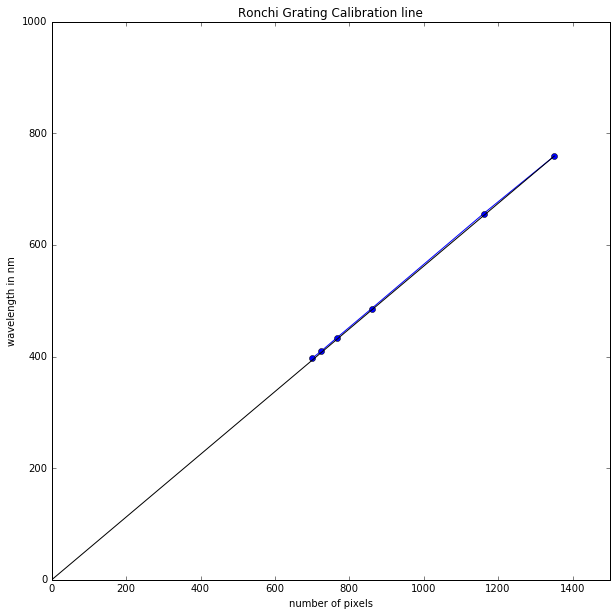

In [93]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.plot(pixel_axis,wavelength_axis,'o-')
plt.plot([0,1351],[0,759.370],'k-')
plt.title('Ronchi Grating Calibration line')
plt.xlabel('number of pixels')
plt.ylabel('wavelength in nm')
plt.ylim(0,1000.)
plt.xlim(0,1500.)

In [94]:
from scipy.interpolate import UnivariateSpline

In [95]:
pixel_to_wavelength_spl = UnivariateSpline(pixel_axis,wavelength_axis)

In [96]:
wavelehgth_to_pixel_spl = UnivariateSpline(wavelength_axis,pixel_axis)

In [97]:
pixel_to_wavelength_spl(indexes_O2[0])

array([ 759.36766408])

In [98]:
index_O2=np.where(specsum==peak_O2)

In [99]:
pixel_axis[:,0].shape

(6,)

In [100]:
wavelength_axis.shape

(6,)

In [101]:
#np.polyfit(pixel_axis[:,0],wavelength_axis,1,full=True)
np.polyfit(pixel_axis[:,0],wavelength_axis,1)

array([ 0.55890252,  5.54556448])

In [115]:
specsum_indexes=np.arange(specsum.shape[0])

In [116]:
specsum_wavelength=pixel_to_wavelength_spl(specsum_indexes)

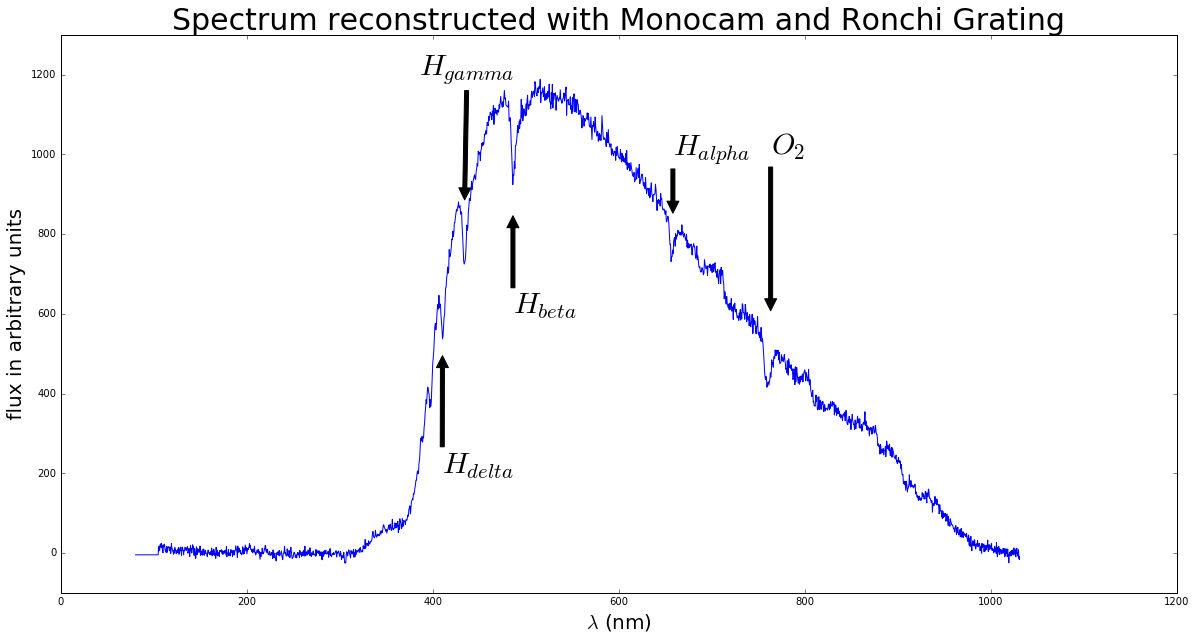

In [160]:
plt.figure(figsize=(20.,10.))
plt.plot(specsum_wavelength,specsum)
plt.title('Spectrum reconstructed with Monocam and Ronchi Grating',fontsize=30)
plt.xlabel('$\lambda$ (nm)',fontsize=20)
plt.ylabel(' flux in arbitrary units ',fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
plt.ylim(-100.,1300.)
plt.annotate('$O_2$', xy=(763.370,600), xytext=(763.37, 1000),fontsize=30,
            arrowprops=dict(facecolor='black', shrink=0.02))
plt.annotate('$H_{alpha}$', xy=(658.281,850), xytext=(658.281, 1000),fontsize=30,
            arrowprops=dict(facecolor='black', shrink=0.02))
plt.annotate('$H_{beta}$', xy=(486.281,850), xytext=(486.281, 600),fontsize=30,
            arrowprops=dict(facecolor='black', shrink=0.02))
plt.annotate('$H_{gamma}$', xy=(434.281,880), xytext=(385.281, 1200),fontsize=30,
            arrowprops=dict(facecolor='black', shrink=0.02))
plt.annotate('$H_{delta}$', xy=(410.500,500), xytext=(410.281, 200),fontsize=30,
            arrowprops=dict(facecolor='black', shrink=0.02))
#wavelength_axis=np.array([397.0, 410.175, 434.047,486.134, 656.281, 759.370])


## SED

In [102]:
path_sed='/Users/dagoret-campagnesylvie/iraf/hdstar_images'
basefilename_sed='hd158485_stis_003.fits'
fullfilename_sed=os.path.join(path_sed,basefilename_sed)
print fullfilename_sed

/Users/dagoret-campagnesylvie/iraf/hdstar_images/hd158485_stis_003.fits


In [103]:
hdulist=fits.open(fullfilename_sed)
hdulist.info()


Filename: /Users/dagoret-campagnesylvie/iraf/hdstar_images/hd158485_stis_003.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      71   ()              
1    SCI         BinTableHDU     39   4683R x 7C   [1D, 1E, 1E, 1E, 1E, 1I, 1E]   


In [104]:
table_data=hdulist[1].data
table_data.columns  # shows the columns names of the table

ColDefs(
    name = 'WAVELENGTH'; format = '1D'; unit = 'ANGSTROMS'; disp = 'G10.4'
    name = 'FLUX'; format = '1E'; unit = 'FLAM'; disp = 'E12.4'
    name = 'STATERROR'; format = '1E'; unit = 'FLAM'; disp = 'E12.4'
    name = 'SYSERROR'; format = '1E'; unit = 'FLAM'; disp = 'E12.4'
    name = 'FWHM'; format = '1E'; unit = 'ANGSTROMS'; disp = 'G6.2'
    name = 'DATAQUAL'; format = '1I'; unit = 'NONE'; disp = 'I2'
    name = 'TOTEXP'; format = '1E'; unit = 'SEC'; disp = 'G10.2'
)

In [105]:
wavelengths=table_data['WAVELENGTH'] # in Angstrom
fluxes=table_data.field('FLUX')

In [106]:
stop_indexes=np.where( np.abs(wavelengths-10000.)<3)
maxindex=np.max(stop_indexes)
print maxindex

3729


In [107]:
wavelengths_cut=wavelengths[:maxindex]
fluxes_cut=fluxes[:maxindex]

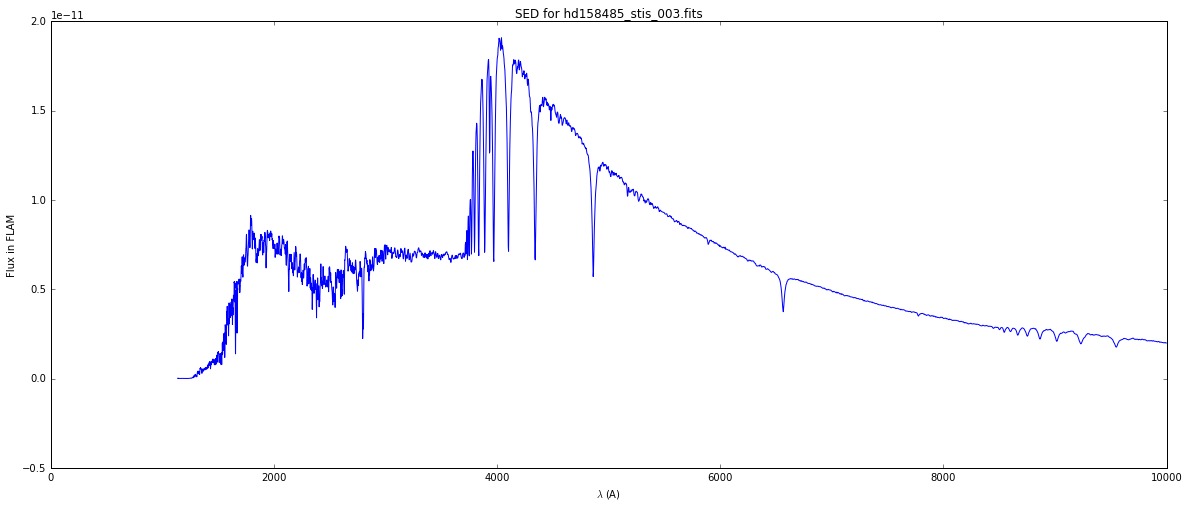

In [108]:
plt.figure(figsize=(20.,8.))
plt.plot(wavelengths_cut,fluxes_cut)
title='SED for {}'.format(basefilename_sed)
figfilename='SED_{}'.format(basefilename.split('.')[0])+'.pdf'
plt.xlabel('$\lambda$ (A)')
plt.ylabel('Flux in FLAM')
plt.title(title)
plt.xlim(0.,10000.)
plt.savefig(figfilename)

In [109]:
table_data=hdulist[1].data
wavelength=table_data['WAVELENGTH'] # in Angstrom
fluxes=table_data.field('FLUX')

The visible spectrum of light from hydrogen displays four wavelengths, 
- 410 nm, 
- 434 nm, 
- 486 nm,
- 656 nm, 

that correspond to emissions of photons by electrons in excited states transitioning to the quantum level described by the principal quantum number n equals 2.[1] There are also a number of ultraviolet Balmer lines with wavelengths shorter than 400 nm.

    Designation 	Element 	Wavelength (nm)
    y 	O2 	898.765
    Z 	O2 	822.696
    A 	O2 	759.370
    B 	O2 	686.719
    C 	Hα 	656.281
    a 	O2 	627.661
    D1 	Na 	589.592
    D2 	Na 	588.995
    D3 or d 	He 	587.5618
    e 	Hg 	546.073
    E2 	Fe 	527.039
    b1 	Mg 	518.362
    b2 	Mg 	517.270
    b3 	Fe 	516.891
    b4 	Mg 	516.733
	
    Designation 	Element 	Wavelength (nm)
    c 	Fe 	495.761
    F 	Hβ 	486.134
    d 	Fe 	466.814
    e 	Fe 	438.355
    G' 	Hγ 	434.047
    G 	Fe 	430.790
    G 	Ca 	430.774
    h 	Hδ 	410.175
    H 	Ca+ 	396.847
    K 	Ca+ 	393.366
    L 	Fe 	382.044
    N 	Fe 	358.121
    P 	Ti+ 	336.112
    T 	Fe 	302.108
    t 	Ni 	299.444


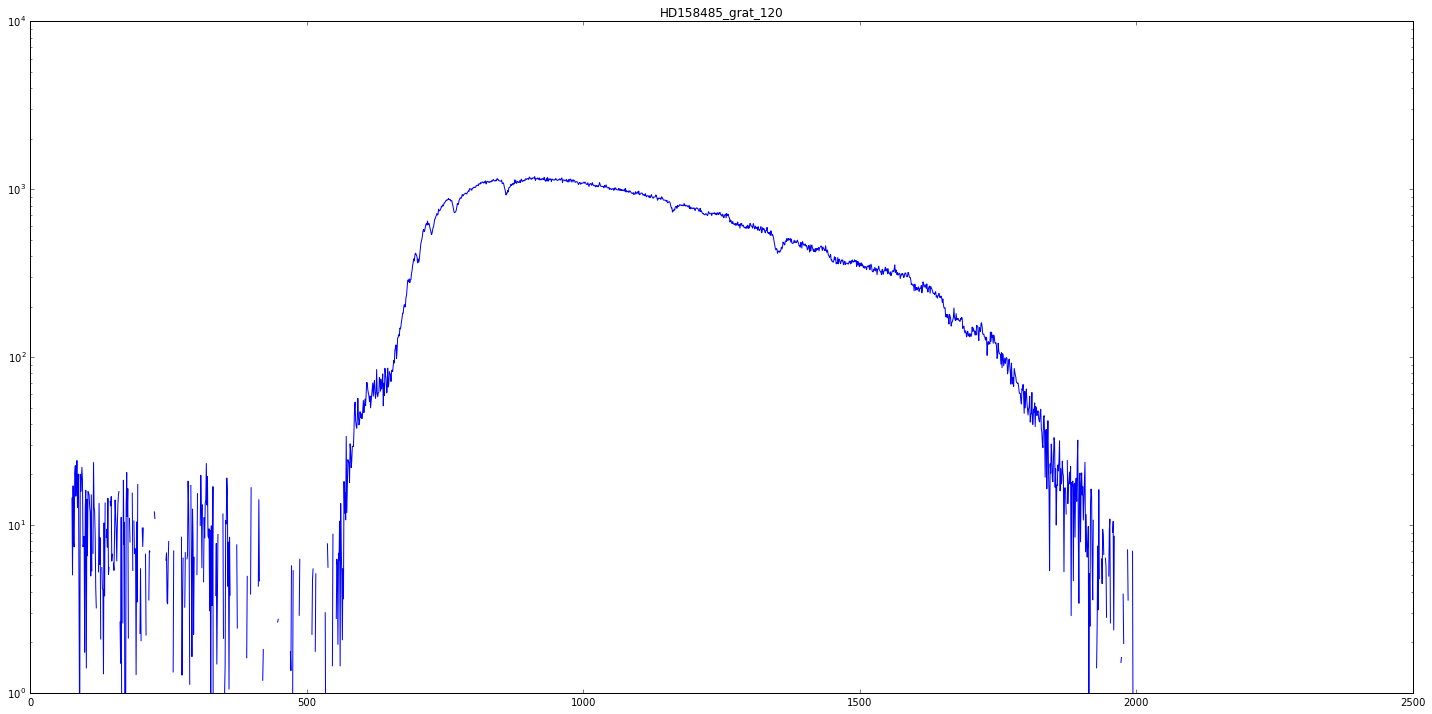

In [110]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.semilogy(specsum)
plt.ylim(1.,10000.)
plt.title(object_name)
plt.tight_layout()
plt.savefig(outputfigfilename7)

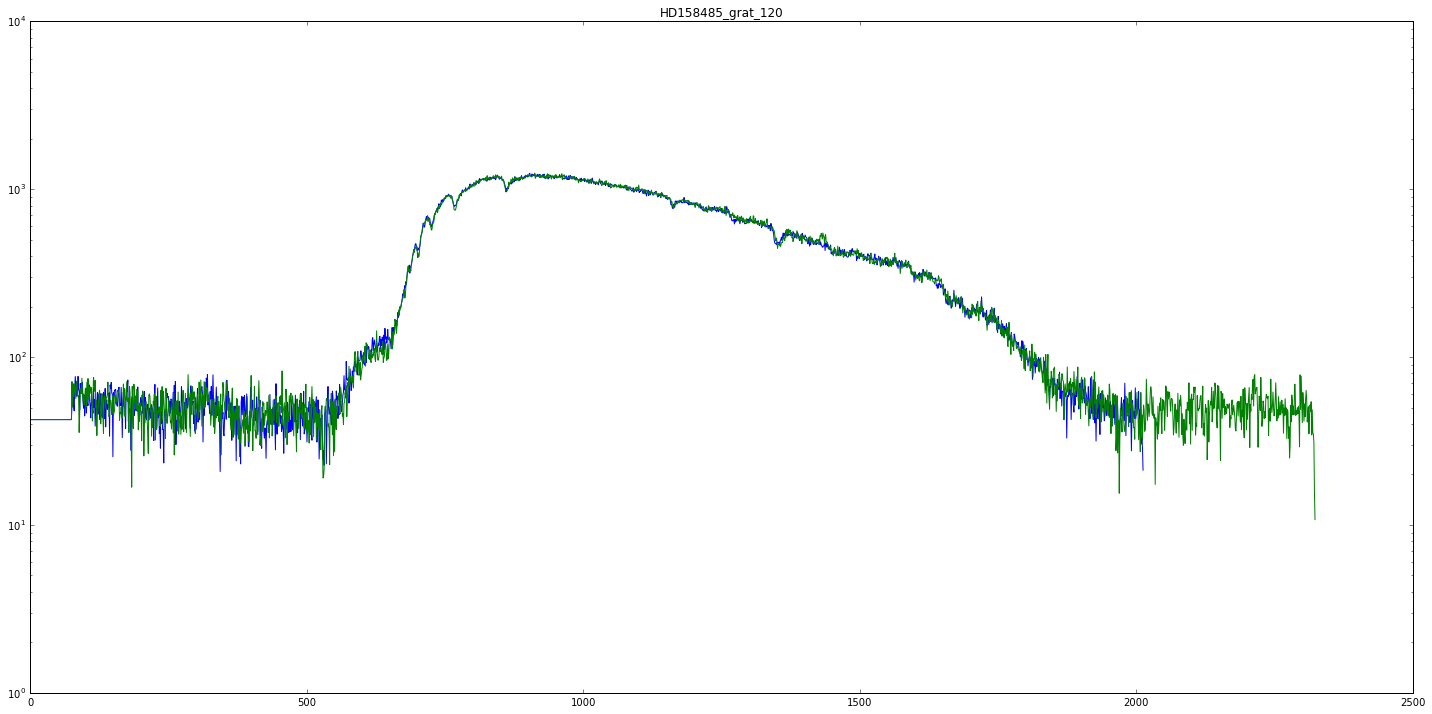

In [111]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.semilogy(spec1)
plt.semilogy(spec2)
plt.ylim(1.,10000.)
plt.title(object_name)
plt.tight_layout()
plt.savefig(outputfigfilename7)